In [1]:
import time
import random
import math
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import tiktoken

print('All imports done.')

/Users/gprajeshkumar/Documents/NYU Courant/Machine Learning/hws/pico-llm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gprajeshkumar/Documents/NYU Courant/Machine Learning/hws/pico-llm/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


All imports done.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


### Hyperparameters

For Data
1. block_size
2. train_subset_size
3. batch_size
4. tinystories_weights


In [4]:
# Data parameters
block_size = 128  # Sequence length for training
train_subset_size = 20000  # Number of samples to use from TinyStories
batch_size = 16

tinystories_weight = 0.5  # Proportion of TinyStories in mixed dataset (0.0 to skip)


In [11]:
# Load tokenizer
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab

# Load TinyStories dataset
tinystories_seqs = []
if tinystories_weight > 0.0:
    print(f"Loading TinyStories from huggingface with weight={tinystories_weight}...")
    dataset = load_dataset("roneneldan/TinyStories", split="train")
    dataset = dataset.select(range(train_subset_size))
    for sample in dataset:
        text = sample['text']
        tokens = enc.encode(text)
        tokens = tokens[:block_size]
        if len(tokens) > 0:
            tinystories_seqs.append(tokens)
    print(f"TinyStories sequences: {len(tinystories_seqs)}")
else:
    print("TinyStories weight=0 => skipping TinyStories.")
other_seqs = []

Loading TinyStories from huggingface with weight=0.5...
TinyStories sequences: 20000


In [8]:
class MixedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, tinystories_seqs, other_seqs, p_tiny: float):
        super().__init__()
        self.tinystories_seqs = tinystories_seqs
        self.other_seqs = other_seqs
        self.p_tiny = p_tiny
        self.has_tinystories = (len(self.tinystories_seqs) > 0)
        self.has_other = (len(self.other_seqs) > 0)
        self.total_length = len(self.tinystories_seqs) + len(self.other_seqs)
        if self.total_length == 0:
            raise ValueError("No data found! Both TinyStories and other sets are empty.")

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        import random
        r = random.random()
        if self.has_tinystories and self.has_other:
            if r < self.p_tiny:
                i = random.randint(0, len(self.tinystories_seqs) - 1)
                seq = self.tinystories_seqs[i]
            else:
                i = random.randint(0, len(self.other_seqs) - 1)
                seq = self.other_seqs[i]
        elif self.has_tinystories:
            i = random.randint(0, len(self.tinystories_seqs) - 1)
            seq = self.tinystories_seqs[i]
        else:
            i = random.randint(0, len(self.other_seqs) - 1)
            seq = self.other_seqs[i]
        return torch.tensor(seq, dtype=torch.long)

In [9]:
def seq_collate_fn(batch):
    max_len = max(len(seq) for seq in batch)
    batch_size = len(batch)
    padded = torch.zeros(max_len, batch_size, dtype=torch.long)
    for i, seq in enumerate(batch):
        seq_len = seq.size(0)
        padded[:seq_len, i] = seq
    return padded

In [12]:
# Create dataset and loader
p_tiny = tinystories_weight
combined_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_seqs,
    other_seqs=other_seqs,
    p_tiny=p_tiny
)

In [14]:
combined_dataset.total_length

20000

Num sequences used: 20000  |  min/max/median length: 53/128/128


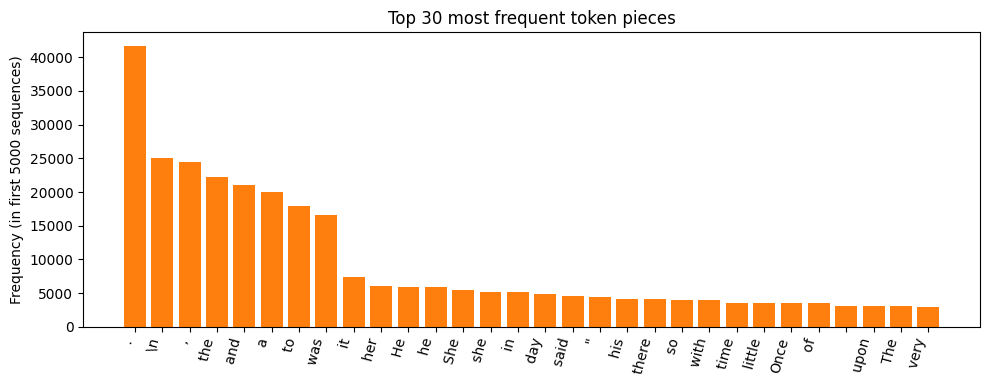

Decoded samples:


,sample_idx,text
0,0,"One day, a little boy named Tim went to the park with his mom. Tim brought his favorite toy, a ball, in a sack. At the park, Tim played with other kids and had a lot of fun. They ran, jumped, and laughed together. Tim was very happy.\n\nAfter playing for a long time, Tim wanted to eat a tasty snack. His mom gave him a yummy apple to eat. While Tim was eating, he forgot about his ball in the sa..."
1,1,"Once upon a time, there was a boy named Toby who was very excited. He was playing in the park with his friends when he saw a twig that was very shiny. He rushed over to it and grabbed it quickly.\n\n""What is this?"" Toby asked, looking at the twig in his hand. His friends gathered around to look too.\n\n""That looks like a special twig,"" said one of his friends. ""It could be worth something.""\n\..."
2,2,"Once upon a time there was a little girl. She was just three years old and wanted to explore the world.\n\nOne day she went out and found an unknown tree. It was huge and so tall it touched the sky.\n\nThe little girl was amazed and wanted to climb it, so she started to lean against the trunk and she managed to climb up.\n\nWhen she reached the top, she was delighted. She could see so far and ..."
3,3,"Once upon a time, there was a shy little bunny named Floppy. Floppy loved to travel around the forest and meet new friends. One day, Floppy met a friendly squirrel named Nutty. They played together and had fun.\n\nAfter a while, they decided to play a game of hide-and-seek. Nutty was very good at hiding, and Floppy had a hard time finding him. Finally, Floppy found Nutty hiding in a tree. They..."
4,4,"Once upon a time, there was an adorable clown. His name was Buddy and he lived in a bright and colourful tent.\nOne day, Buddy was feeling sad so he decided to go for a walk.\nHe stumbled upon a boy who was also feeling down.\nThe boy said to him, â€œHi clown! What are you doing here?â€\n\nBuddy smiled and said, â€œIâ€™m sad and I hope to find something to make me happy. Do you have any ideas?..."
5,5,"Once upon a time, there was a little boy named Timmy. Timmy loved to hold his teddy bear tightly when he went to bed at night. One day, Timmy went to the park to play with his friends. They were having so much fun on the swings and slides, but then Timmy realized he lost his watch. He started to cry because it was a special gift from his grandma.\n\nTimmy's friend, Johnny, saw him crying and a..."


In [18]:
import numpy as np
from collections import Counter
import random
import pandas as pd

# Visualize TinyStories / mixed dataset: lengths, top tokens, and some decoded samples.
import matplotlib.pyplot as plt

# 1) Sequence length distribution (use tinystories_seqs if available, else sample from combined_dataset)
if len(tinystories_seqs) > 0:
    seqs_for_stats = tinystories_seqs
else:
    # sample some sequences from combined_dataset
    seqs_for_stats = [combined_dataset[i].tolist() for i in range(min(len(combined_dataset), 2000))]

lengths = [len(s) for s in seqs_for_stats]
print(f"Num sequences used: {len(seqs_for_stats)}  |  min/max/median length: {np.min(lengths)}/{np.max(lengths)}/{int(np.median(lengths))}")


N_seq = min(5000, len(seqs_for_stats))
counter = Counter()
for seq in seqs_for_stats[:N_seq]:
    counter.update(seq)
topk = counter.most_common(30)
ids, counts = zip(*topk)
labels = [enc.decode([i]).replace("\n", "\\n") for i in ids]

plt.figure(figsize=(10,4))
plt.bar(range(len(ids)), counts, color='C1')
plt.xticks(range(len(ids)), labels, rotation=75, ha='right')
plt.ylabel("Frequency (in first %d sequences)" % N_seq)
plt.title("Top 30 most frequent token pieces")
plt.tight_layout()
plt.show()

n_show = 6
samples = []
if len(tinystories_seqs) > 0:
    chosen = random.sample(range(len(tinystories_seqs)), min(n_show, len(tinystories_seqs)))
    for i in chosen:
        samples.append(enc.decode(tinystories_seqs[i]))
else:
    for _ in range(n_show):
        seq = combined_dataset[random.randint(0, len(combined_dataset)-1)].tolist()
        samples.append(enc.decode(seq))

df = pd.DataFrame({"sample_idx": range(len(samples)), "text": samples})
pd.set_option("display.max_colwidth", 400)
print("Decoded samples:")
display(df)



Analyzing original (pre-truncation) vs truncated sequence lengths...


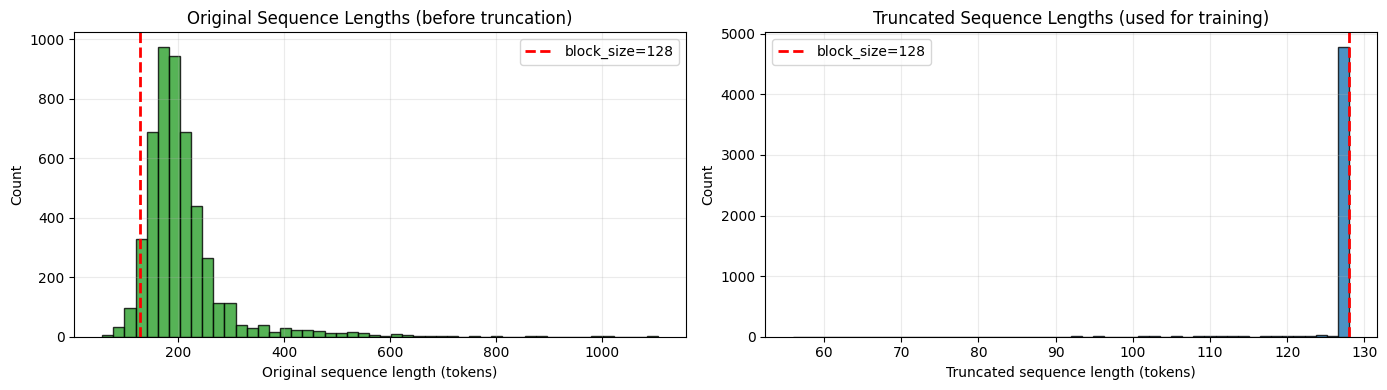


Statistics (from 5000 samples):
  Original lengths - min: 56, max: 1106, median: 189
  95.2% of sequences were truncated (longer than 128 tokens)


In [17]:
# Compare original vs truncated sequence lengths
if tinystories_weight > 0.0 and dataset is not None:
    print("Analyzing original (pre-truncation) vs truncated sequence lengths...")
    
    # Sample a subset for analysis
    n_samples = min(5000, len(dataset))
    original_lengths = []
    truncated_lengths = []
    
    for i in range(n_samples):
        text = dataset[i]['text']
        tokens = enc.encode(text)
        original_lengths.append(len(tokens))
        truncated_lengths.append(min(len(tokens), block_size))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Original lengths
    axes[0].hist(original_lengths, bins=50, color='C2', edgecolor='k', alpha=0.8)
    axes[0].axvline(block_size, color='red', linestyle='--', linewidth=2, label=f'block_size={block_size}')
    axes[0].set_xlabel("Original sequence length (tokens)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Original Sequence Lengths (before truncation)")
    axes[0].legend()
    axes[0].grid(alpha=0.25)
    
    # Truncated lengths
    axes[1].hist(truncated_lengths, bins=50, color='C0', edgecolor='k', alpha=0.8)
    axes[1].axvline(block_size, color='red', linestyle='--', linewidth=2, label=f'block_size={block_size}')
    axes[1].set_xlabel("Truncated sequence length (tokens)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Truncated Sequence Lengths (used for training)")
    axes[1].legend()
    axes[1].grid(alpha=0.25)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    pct_truncated = 100 * sum(1 for l in original_lengths if l > block_size) / len(original_lengths)
    print(f"\nStatistics (from {n_samples} samples):")
    print(f"  Original lengths - min: {min(original_lengths)}, max: {max(original_lengths)}, median: {int(np.median(original_lengths))}")
    print(f"  {pct_truncated:.1f}% of sequences were truncated (longer than {block_size} tokens)")
else:
    print("Skipping original vs truncated comparison (no TinyStories data loaded)")


In [19]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("DataLoader ready. Vocab size:", vocab_size)

DataLoader ready. Vocab size: 50257


In [20]:
# Peek inside the DataLoader to understand its contents
# Note: this will only inspect a single batch for presentation.

# Get one batch from the train_loader
example_batch = next(iter(train_loader))

print("Type of batch:", type(example_batch))
print("Batch tensor shape:", example_batch.shape)
print("  -> (seq_len, batch_size)")
print()

# Show a small slice of token IDs
print("First 10 token IDs of first sequence in batch:")
print(example_batch[:10, 0].tolist())
print()

# Decode a few sequences to readable text for illustration
n_examples_to_show = 3
for idx in range(min(n_examples_to_show, example_batch.shape[1])):
    token_ids = example_batch[:, idx].tolist()
    # remove trailing zeros (padding)
    if 0 in token_ids:
        pad_start = token_ids.index(0)
        token_ids = token_ids[:pad_start]
    text = enc.decode(token_ids)
    print(f"--- Example {idx} (length={len(token_ids)} tokens) ---")
    print(text[:500])  # truncate for presentation
    print()

Type of batch: <class 'torch.Tensor'>
Batch tensor shape: torch.Size([128, 16])
  -> (seq_len, batch_size)

First 10 token IDs of first sequence in batch:
[7454, 2402, 257, 640, 11, 612, 373, 257, 2576, 508]

--- Example 0 (length=128 tokens) ---
Once upon a time, there was a girl who loved to imagine. She would close her eyes and imagine wonderful things.

One day, she saw a frame lying on the ground. She picked it up and guessed that it had been left behind by someone who had forgotten it. She looked closely and noticed that, inside the frame were two dead butterflies.

The girl started to imagine what would happen if the butterflies could come alive again. She thought of them fluttering from flower to flower and of the trees swaying i

--- Example 1 (length=128 tokens) ---
One day, a little girl named Lily and her mom went for a walk in the park. It was a foggy day and Lily loved how the fog made everything look like a mystery. As they walked, they saw a man drawing on a big piece o

In [1]:
import torch
print(f"torch backend MPS is available? {torch.backends.mps.is_available()}")
print(f"current PyTorch installation built with MPS activated? {torch.backends.mps.is_built()}")
print(f"check the torch MPS backend: {torch.device('mps')}")
print(f"test torch tensor on MPS: {torch.tensor([1,2,3], device='mps')}")   

torch backend MPS is available? True
current PyTorch installation built with MPS activated? True
check the torch MPS backend: mps
test torch tensor on MPS: tensor([1, 2, 3], device='mps:0')
